# Fit a smooth source & compute evidence
### Fit a Sérsic source assuming a fixed parametric lens (SIE + shear), and compare different methods to estimate the Bayesian evidence

__last update__: 13/07/21

In [1]:
# Basic imports
import matplotlib.pyplot as plt
%matplotlib inline
import numpy as np
from copy import deepcopy
import corner
import dynesty
from dynesty import plotting as dyplot
from jaxns.nested_sampling import NestedSampler
from jaxns.prior_transforms import PriorChain, UniformPrior
from jaxns import utils
from jaxns import plotting

# Basic JAX
import jax
from jax import lax
import jax.numpy as jnp
from jax.config import config
config.update("jax_enable_x64", True)

# JAX-ified lenstronomy
from jaxtronomy.Coordinates.pixel_grid import PixelGrid
from jaxtronomy.Instrument.psf import PSF
from jaxtronomy.Instrument.noise import Noise
from jaxtronomy.LightModel.light_model import LightModel
from jaxtronomy.LensModel.lens_model import LensModel
from jaxtronomy.LensImage.lens_image import LensImage
from jaxtronomy.Parameters.parameters import Parameters
from jaxtronomy.Inference.loss import Loss
from jaxtronomy.Inference.optimization import Optimizer
from jaxtronomy.Inference.sampling import Sampler
from jaxtronomy.Util import image_util

# Universal font size
FS = 18

### Data grids (image plane and source plane)
For simplicity at first, assume both share the same pixelization.

In [2]:
npix = 100
pix_scl = 0.08  # arcsec / pixel
half_size = npix * pix_scl / 2
ra_at_xy_0 = dec_at_xy_0 = -half_size + pix_scl / 2
transform_pix2angle = pix_scl * np.eye(2)
kwargs_pixel = {'nx': npix, 'ny': npix,
                'ra_at_xy_0': ra_at_xy_0, 'dec_at_xy_0': dec_at_xy_0,
                'transform_pix2angle': transform_pix2angle}
pixel_grid = PixelGrid(**kwargs_pixel)
xgrid, ygrid = pixel_grid.pixel_coordinates

print(f"image size : ({npix}, {npix}) pixels")
print(f"pixel size : {pix_scl} arcsec")
print(f"x range    : {xgrid[0, 0], xgrid[0, -1]} arcsec")
print(f"y range    : {ygrid[0, 0], ygrid[-1, 0]} arcsec")

image size : (100, 100) pixels
pixel size : 0.08 arcsec
x range    : (-3.96, 3.96) arcsec
y range    : (-3.96, 3.96) arcsec


### Source light model

In [3]:
source_light_model_list = ['SERSIC']
source_light_model = LightModel(source_light_model_list)
kwargs_source_light = [{'amp': 10.0, 'R_sersic': 1.2, 'n_sersic': 1.5, 'center_x': 0.4, 'center_y': 0.15}]

### Lens model (SIE + external shear)

In [4]:
# Lens mass
lens_mass_model_list = ['SIE', 'SHEAR']
lens_mass_model = LensModel(lens_mass_model_list)
kwargs_lens_mass = [{'theta_E': 1.6, 'e1': 0.15, 'e2': -0.04, 'center_x': 0.0, 'center_y': 0.0},
                    {'gamma1': -0.01, 'gamma2': 0.03, 'ra_0': 0.0, 'dec_0': 0.0}]

# Lens light
lens_light_model_list = []
lens_light_model = LightModel(lens_light_model_list)
kwargs_lens_light = [{}]

### PSF

In [5]:
kwargs_psf = {'psf_type': 'GAUSSIAN', 'fwhm': 0.3}
psf = PSF(**kwargs_psf)

### Noise

In [6]:
exp_time = 100
sigma_bkd = 0.05
kwargs_noise = {'background_rms': sigma_bkd, 'exposure_time': exp_time}
noise = Noise(npix, npix, **kwargs_noise)

### Image model

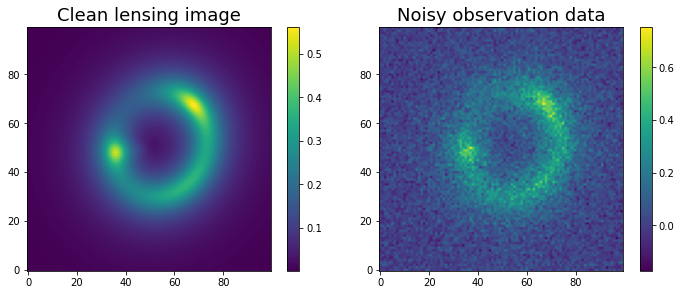

In [7]:
# Generate a lensed image based on source and lens models
lens_image = LensImage(data_class=pixel_grid,
                         psf_class=psf,
                         noise_class=noise,
                         lens_model_class=lens_mass_model,
                         source_model_class=source_light_model,
                         lens_light_model_class=lens_light_model,
                         kwargs_numerics={'supersampling_factor': 1})

image = lens_image.model(kwargs_lens=kwargs_lens_mass,
                          kwargs_source=kwargs_source_light,
                          kwargs_lens_light=kwargs_lens_light)

data = lens_image.simulation(compute_true_noise_map=True,
                             kwargs_lens=kwargs_lens_mass,
                             kwargs_source=kwargs_source_light,
                             kwargs_lens_light=kwargs_lens_light)

# Plot
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(10, 4))
img1 = ax1.imshow(image, origin='lower')
ax1.set_title("Clean lensing image", fontsize=FS)
img2 = ax2.imshow(data, origin='lower')
ax2.set_title("Noisy observation data", fontsize=FS)
for img, ax in zip((img1, img2), (ax1, ax2)):
    fig.colorbar(img, ax=ax)
fig.tight_layout()

## Source fitting

### Parameter class

We set our initial values for the parameters we want to optimise, and set fixed parameters (here we fix source parameters to the truth). We also set possible priors among `'uniform'` and `'gaussian'` for a subset of parameters.

In [8]:
kwargs_model = {
    'lens_model_list': lens_mass_model_list,
    'source_model_list': source_light_model_list,
    'lens_light_model_list': lens_light_model_list,
}
kwargs_init = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{'amp': 8.0, 'R_sersic': 1.1, 'n_sersic': 1.3, 'center_x': 0.25, 'center_y': 0.1}],
}
kwargs_prior = {
    'kwargs_lens': [{}, {}],
    'kwargs_source': [{'amp': ['uniform', 6., 14.], 'R_sersic': ['uniform', 1., 1.4], 'n_sersic': ['uniform', 1., 2.], 'center_x': ['uniform', 0.2, 0.6], 'center_y': ['uniform', -0.05, 0.35]}],
}
kwargs_fixed = {
    'kwargs_lens': kwargs_lens_mass,
    'kwargs_source': [{}],
}
parameters = Parameters(kwargs_model, kwargs_init, kwargs_prior, kwargs_fixed)

kwargs_true = {'kwargs_lens': kwargs_lens_mass, 'kwargs_source': kwargs_source_light}
p_true = parameters.kwargs2args(kwargs_true)
param_names = parameters.names
print("truths:", p_true, param_names)

print(parameters.prior_types)
print(parameters.bounds)
print(parameters.log_prior(parameters.initial_values()))

truths: [10.    1.2   1.5   0.4   0.15] ['amp', 'R_sersic', 'n_sersic', 'center_x', 'center_y']
['uniform', 'uniform', 'uniform', 'uniform', 'uniform']
(array([ 6.  ,  1.  ,  1.  ,  0.2 , -0.05]), array([14.  ,  1.4 ,  2.  ,  0.6 ,  0.35]))
0.0


### Loss function

In [9]:
loss = Loss(data, lens_image, parameters, likelihood_type='chi2')
grad_loss = jax.jit(jax.grad(loss))

Check loss and gradient of the true parameters

In [10]:
loss(p_true)

DeviceArray(4886.08384749, dtype=float64)

In [11]:
grad_loss(p_true)

DeviceArray([ -14.56219752, -175.46938588,  -26.88837947, -256.70844097,
              -33.30930624], dtype=float64)

### Minimize the loss function over source parameters using scipy

In [12]:
# Optimise !
optimizer = Optimizer(loss, parameters)
best_fit, logL, extra_fields, runtime \
    = optimizer.minimize(method='BFGS', restart_from_init=True)
print(f"Runtime: {runtime}")
kwargs_final = deepcopy(parameters.ML_values(as_kwargs=True))

Runtime: 1.7403199672698975


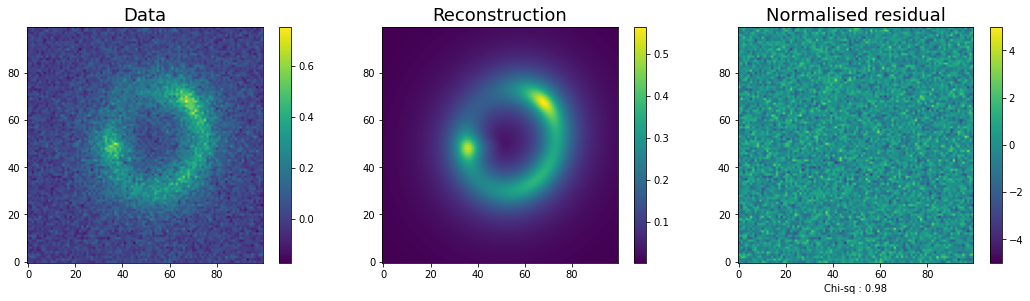

In [13]:
def plot_image_model(kwargs):
    rec = lens_image.model(**kwargs)
    noise_var = lens_image.Noise.C_D

    fig, axes = plt.subplots(1, 3, figsize=(15, 4))
    ax1, ax2, ax3 = axes
    img1 = ax1.imshow(data, origin='lower')
    ax1.set_title("Data", fontsize=FS)
    img2 = ax2.imshow(rec, origin='lower')
    ax2.set_title("Reconstruction", fontsize=FS)
    img3 = ax3.imshow((data - rec) / jnp.sqrt(noise_var), origin='lower', vmin=-5, vmax=5)
    ax3.set_title("Normalised residual", fontsize=FS)
    red_chi2 = np.sum((data - rec)**2 / noise_var) / data.size
    ax3.set_xlabel(f"Chi-sq : {red_chi2:.2f}")
    for img, ax in zip((img1, img2, img3), axes):
        fig.colorbar(img, ax=ax)
    fig.tight_layout()
    
plot_image_model(kwargs_final)

In [14]:
def print_errors(kwargs):
    def _print_error(name, value, estimate):
        spaces = " " * (10 - len(name))
        if value != 0:
            error = 100 * abs(value - estimate) / value
            print(name + ":" + spaces + f"{error:.2f} %")
        else:
            error = abs(value - estimate)
            print(name + ":" + spaces + f"{error:.2f} (abs)")
    print("Error")
    print("-----")
    for i, params in enumerate(kwargs_source_light):
        for key, value in params.items():
            fit = kwargs['kwargs_source'][i][key]
            _print_error(key, value, fit)
        
print_errors(kwargs_final)

Error
-----
amp:       0.30 %
R_sersic:  1.19 %
n_sersic:  0.12 %
center_x:  1.54 %
center_y:  1.28 %


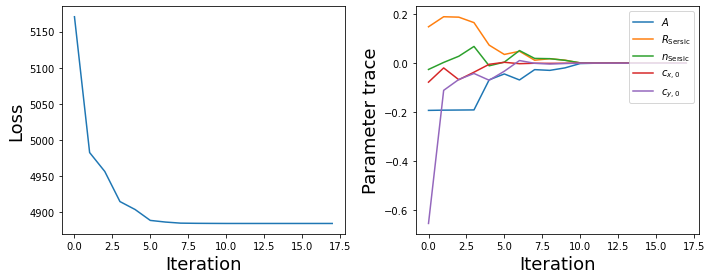

In [15]:
fig, axes = plt.subplots(1, 2, figsize=(10, 4))
ax = axes[0]
ax.plot(range(len(optimizer.loss_history)), optimizer.loss_history)
ax.set_ylabel("Loss", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax = axes[1]
param_history = np.array(optimizer.param_history)
for i in range(len(param_names)):
    ax.plot(range(len(optimizer.loss_history)), (param_history[:, i] - param_history[-1, i]) / param_history[-1, i], label=parameters.symbols[i])
ax.set_ylabel("Parameter trace", fontsize=FS)
ax.set_xlabel("Iteration", fontsize=FS)
ax.legend(loc='upper right')
fig.tight_layout()
plt.show()

### Fisher matrix

Using approximated inverse Hessian


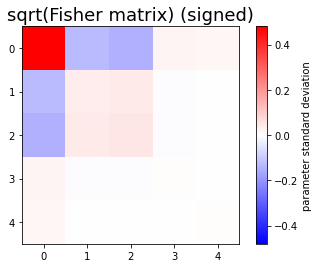

In [16]:
if extra_fields['hess_inv'] is not None:
    print("Using approximated inverse Hessian")
    fisher_matrix = extra_fields['hess_inv']
else:
    print("Using true inverse Hessian")
    hess_ml = optimizer.hessian(best_fit)
    fisher_matrix = jax.numpy.linalg.inv(hess_ml)

sqrt_fisher_matrix = np.sqrt(np.abs(fisher_matrix)) * np.sign(fisher_matrix)
plt.title("sqrt(Fisher matrix) (signed)", fontsize=FS)
plt.imshow(sqrt_fisher_matrix, cmap='bwr', vmin=-np.abs(sqrt_fisher_matrix).max(), vmax=np.abs(sqrt_fisher_matrix).max())
plt.colorbar(label="parameter standard deviation")
plt.show()

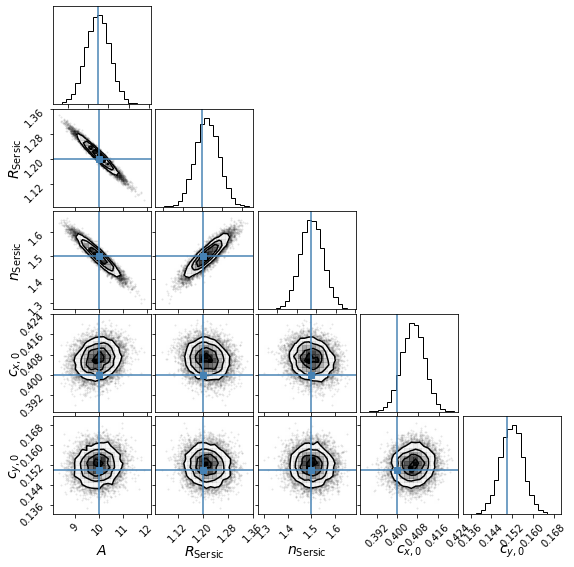

In [17]:
def draw_from_gaussian(mu, S, ndraws=1):
    ndim = len(mu)
    r = np.random.multivariate_normal(mu, S, size=ndraws)
    return r

samples_fisher = draw_from_gaussian(best_fit, fisher_matrix, ndraws=10000)

fig = plt.figure(figsize=(8, 8))
fig = corner.corner(samples_fisher, truths=p_true, show_titles=False, labels=parameters.symbols, 
                    fig=fig, title_kwargs={'fontsize': 14}, label_kwargs={'fontsize': 14})
plt.show()

## Nested sampling to estimate Bayesian evidence

__Warning__: be aware that runtime depends _highly_ on the parameter bounds! So make sure lower and upper limits are tight enough to improve efficiency of nested sampling algorithms.

In [18]:
lowers, uppers = parameters.bounds
print(lowers, uppers)

# below: `u` is the unit cube, `x` are parameters

@jax.jit
def prior_u(u):
    # prior transform from unit cube to parameter cube
    x = lowers + (uppers - lowers) * u
    return x

@jax.jit
def loglike_x(x):
    # log-likelihood to maximise
    return -loss(x)

@jax.jit
def grad_x(x):
    # gradient of the log-likelihood wrt to x
    return jax.grad(loglike_x)(x)

@jax.jit
def grad_u(u):
    # gradient of the log-likelihood wrt to u (i.e. includes jacobian between u and x)
    return jax.grad(loglike_x)(u) * (uppers - lowers)

[ 6.    1.    1.    0.2  -0.05] [14.    1.4   2.    0.6   0.35]


### Using `dynesty` with Hamiltonian slice sampling

In [19]:
# option 1: provide the gradient of the log-l wrt x, and compute numerically the jacobian wrt to u
kwargs_hslice = dict(sample='hslice', gradient=grad_x, compute_jac=True)

# option 2: provide the gradient of the log-l directly wrt u
#kwargs_hslice = dict(sample='hslice', gradient=grad_u, compute_jac=False)

nested_sampler = dynesty.NestedSampler(loglike_x, prior_u, 
                                       parameters.num_parameters, 
                                       nlive=100, **kwargs_hslice)
nested_sampler.run_nested(dlogz=0.1) #maxiter=None, maxcall=None, dlogz=None, logl_max=inf

1807it [20:06,  1.50it/s, +100 | bound: 80 | nc: 1 | ncall: 1018329 | eff(%):  0.187 | loglstar:   -inf < -4884.287 <    inf | logz: -4899.941 +/-  0.524 | dlogz:  0.001 >  0.100]


In [20]:
results = nested_sampler.results
results.summary()

Summary
nlive: 100
niter: 1807
ncall: 1018329
eff(%):  0.187
logz: -4899.941 +/-  0.524


/Users/aymericg/anaconda3/envs/py3jax/lib/python3.7/site-packages/dynesty/plotting.py:245: UserWarning: Attempting to set identical bottom == top == 0.0 results in singular transformations; automatically expanding.
  axes[i].set_ylim([ymin, ymax])


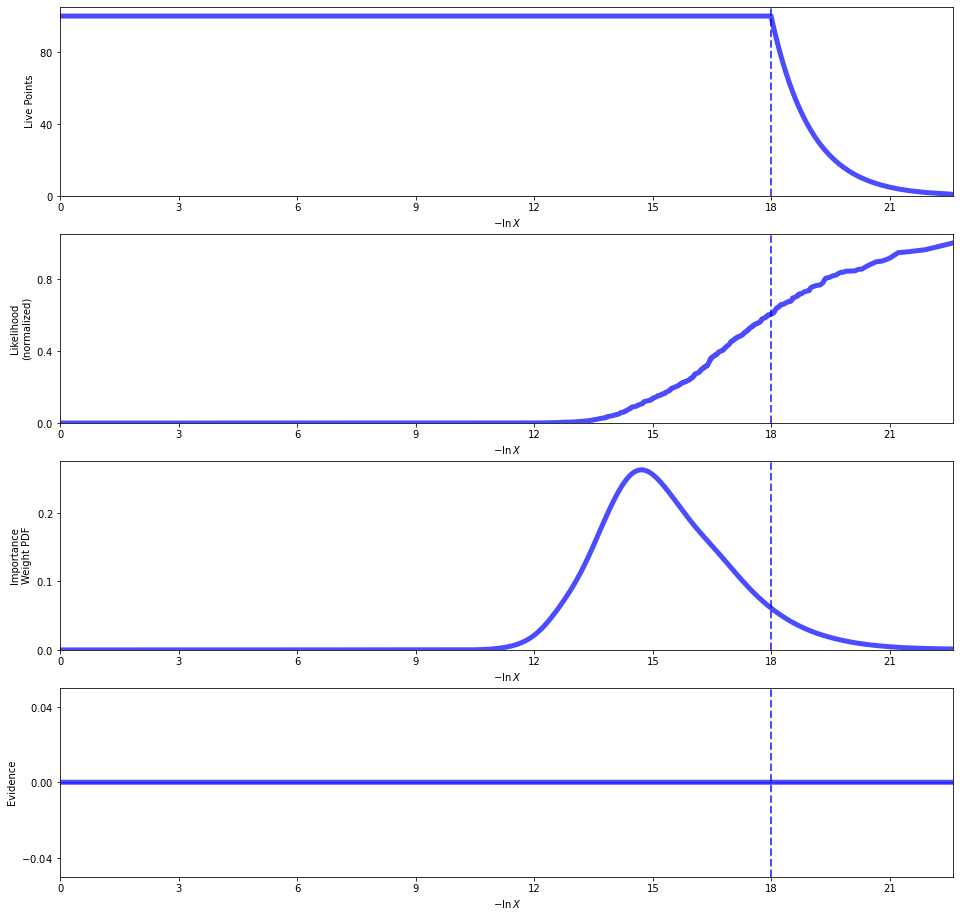

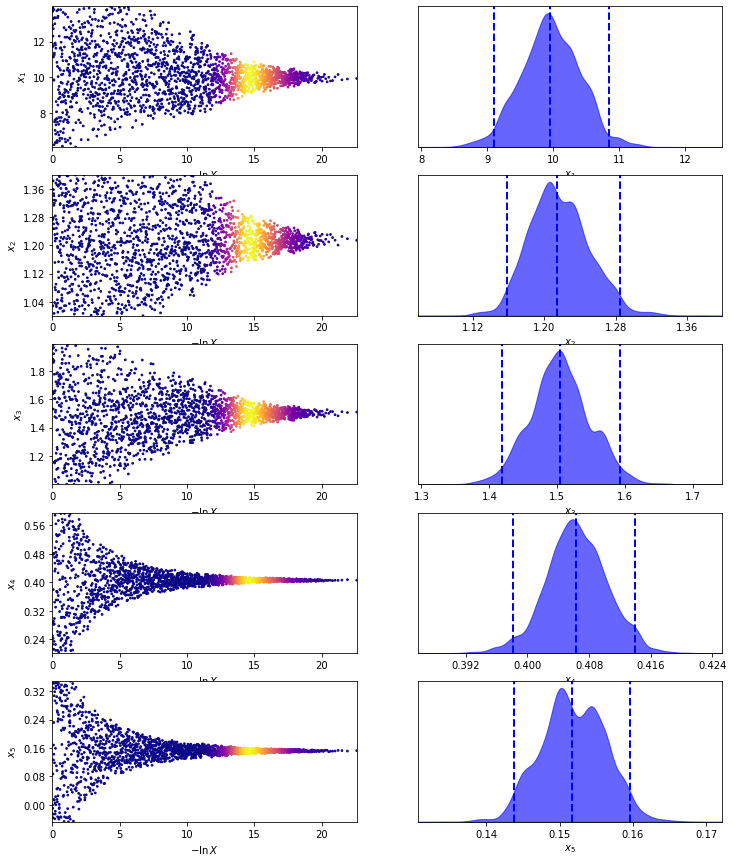

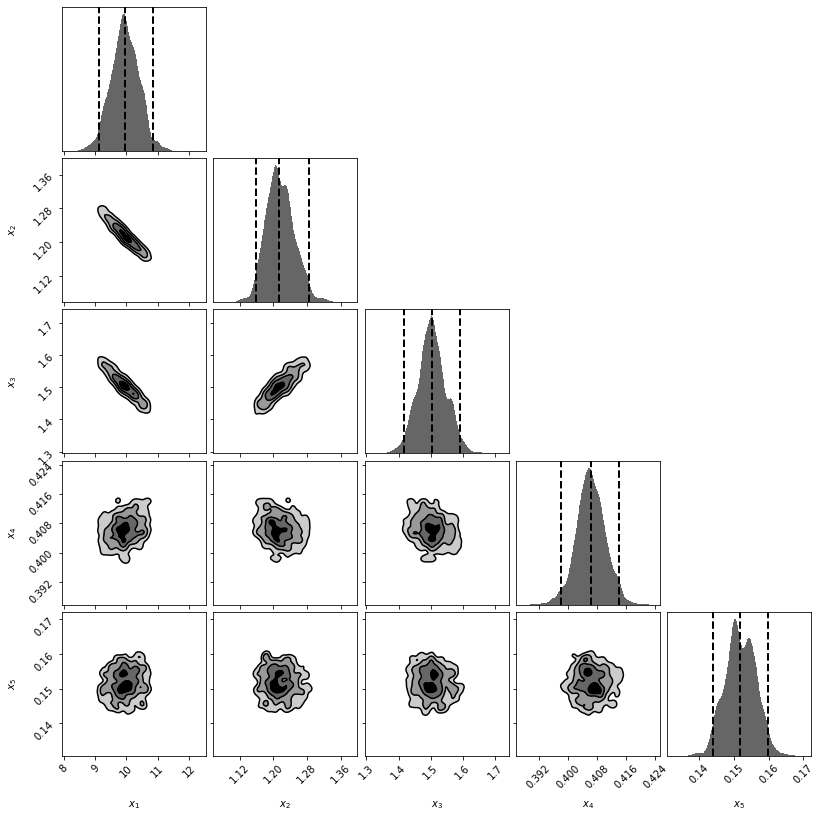

In [21]:
results = nested_sampler.results

# Plot a summary of the run.
rfig, raxes = dyplot.runplot(results)

# Plot traces and 1-D marginalized posteriors.
tfig, taxes = dyplot.traceplot(results)

# Plot the 2-D marginalized posteriors.
cfig, caxes = dyplot.cornerplot(results)

### Using `jaxns` for fast JAX-based backend

In [23]:
@jax.jit
def loglike_x_kw(x, **kwargs):
    return -loss(x)

prior_chain = PriorChain().push(UniformPrior('x', lowers, uppers))

ns = NestedSampler(loglike_x_kw, prior_chain, num_live_points=100)

jaxns_results = jax.jit(ns)(jax.random.PRNGKey(2), termination_frac=0.1)

--------
# likelihood evals: 279509
# samples: 2001
# likelihood evals / sample: 139.7
--------
logZ=-4899.75 +- 0.36
ESS=582
--------
x[#]: mean +- std.dev. | 10%ile / 50%ile / 90%ile | MAP est. | max(L) est.
x[0]: 10.04 +- 0.46 | 9.42 / 10.1 / 10.62 | 10.14 | 9.95
x[1]: 1.211 +- 0.035 | 1.166 / 1.205 / 1.259 | 1.192 | 1.214
x[2]: 1.495 +- 0.048 | 1.435 / 1.491 / 1.557 | 1.461 | 1.505
x[3]: 0.4064 +- 0.0044 | 0.4009 / 0.4067 / 0.4121 | 0.4075 | 0.4065
x[4]: 0.152 +- 0.0043 | 0.1466 / 0.1522 / 0.1575 | 0.1526 | 0.1506
--------


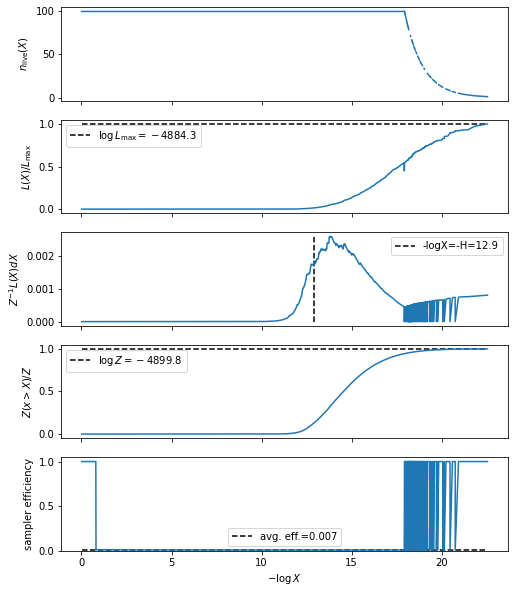

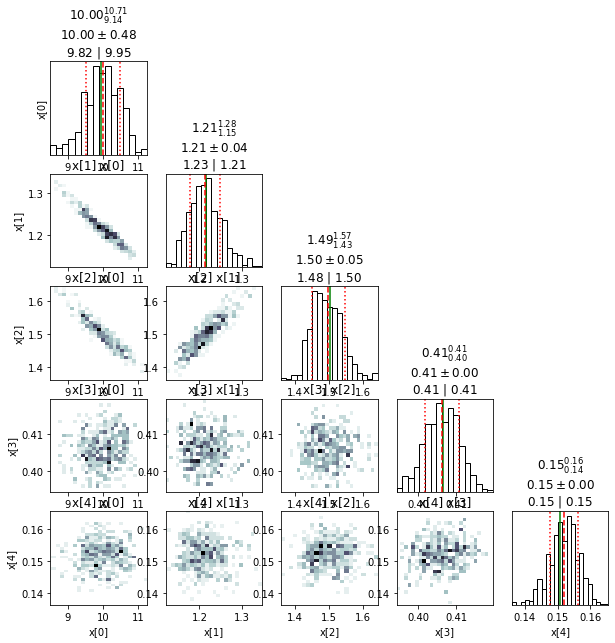

In [24]:
utils.summary(jaxns_results)

plotting.plot_diagnostics(jaxns_results)
plotting.plot_cornerplot(jaxns_results)